# Exploring OPTAA sensor data
In preparation for an OOIFB summer school in July 2023, I am developing a baseline knowledge about the spectrophotometer data that is available from OOI. The week-long summer school will educate OOI data users on how to access OPTAA (Spectrophotometer) instrument data, prepare it for analysis, and where the data comes from.

I am requesting and downloading data from one of the Coastal Pioneer NES array nodes that had an OPTAA instrument on a more recent deployment. After checking the content and structure of the downloaded dataset, I will plot a couple of different views of the data. I am interested in whether annotated data is already removed from the dataset, and how the visualizations I create will compare to what is currently available at [OOI Data Explorer](https:\\dataexplorer.oceanobservatories.org).

In [1]:
# Import modules needed for this notebook

import os
import ooinet
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cmocean.cm as cmo

from ooi_data_explorations import common

# eventually when I have source code in this project folder, I will include the following line:
# import optaa_data_explorations as optaa

In [2]:
# Pick reference designator for instrument of interest
refdes = 'CP01CNSM-RID27-01-OPTAAD000'

[site, node, sensor] = refdes.split('-', 2)

In [3]:
# Show available data recovery methods for refdes (maybe also show metadata)
methods = common.list_methods(site, node, sensor)
methods

['recovered_host', 'telemetered']

In [4]:
# Show available data streams for refdes and method
streams = []
for method in methods: streams.append(common.list_streams(site, node, sensor, method))
streams

[['optaa_dj_dcl_instrument_recovered', 'optaa_dj_dcl_metadata_recovered'],
 ['optaa_dj_dcl_instrument', 'optaa_dj_dcl_metadata']]

In [5]:
# Show deployments for refdes (& get dates? How will this be used to build the data request?)
deployments = common.list_deployments(site, node, sensor)
deployments

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [6]:
# Also show annotations available from OOINet for this sensor
annotations = common.get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
with pd.option_context('display.max_colwidth', None):
  display(annotations["annotation"])

0                                                                                                                                                                                          Per vendor feedback, the first 1-2 min of each AC-S instrument sampling period should be considered suspect. Signal drift can occur as the instrument warms up, flushes with seawater, and the filter wheel spins up.
1                                                                                                                                                                                                                                                                                                                                                                                          Data not telemetered.
2                                                                                                                                                                                                     

In [ ]:
# Pick method, stream, deployment from options shown above
method = methods[0]             # picking recovered host method; check OOINet for data availability to choose the most complete timeseries
stream = streams[0][0]          # data product or metadata; must pick a data stream from the list corresponding to the chosen method (first index)
deployment = deployments[15]    # picking a more recent deployment with less annotations indicating missing or suspect data
[sdt, edt] = common.get_deployment_dates(site, node, sensor, deployment)

# Build path to directory where we'll store data downloaded from OOI
filename = '-'.join([site, node, sensor, method, stream,f"deployment{deployment}"])+'.nc'
filepath = os.path.join(os.path.abspath('../data/external'), filename)

# Try importing locally saved data first
try:
    ds = xr.open_dataset(filepath)
except FileNotFoundError:
    # Otherwise download data with common.m2m_request and common.m2m_collect then write to disk
    data = common.m2m_request(site, node, sensor, method, stream, sdt, edt)
    ds = common.m2m_collect(data, use_dask=True)
    ds.to_netcdf(filepath)

In [9]:
ds

<xarray.Dataset>
Dimensions:                                       (time: 3588534, wavelength: 87)
Coordinates:
  * time                                          (time) datetime64[ns] 2021-...
  * wavelength                                    (wavelength) int32 0 1 ... 86
Data variables: (12/25)
    sea_water_temperature_qartod_results          (time) uint8 ...
    deployment                                    (time) int32 ...
    sea_water_practical_salinity_qartod_executed  (time) object ...
    internal_timestamp                            (time) datetime64[ns] ...
    sea_water_temperature_qartod_executed         (time) object ...
    sea_water_practical_salinity                  (time) float64 ...
    ...                                            ...
    optical_absorption                            (time, wavelength) float64 ...
    c_signal_dark_counts                          (time) float32 ...
    pressure_counts                               (time) float32 ...
    a_signal_dark_counts                          (time) float32 ...
    c_reference_counts                            (time, wavelength) float32 ...
    a_reference_dark_counts                       (time) float32 ...
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             ctdbp_cdef_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.367167
    lon:                                -70.881817

In [12]:
if ds["optical_absorption"].time.size > 100000:
    try:
        subset = sorted(np.random.choice(ds.time,100,replace=False))
        subset_data = ds.sel(time=subset)
        # absorption = subset_data.optical_absorption.to_dataframe(dim_order=["time", "wavelength"])
        # sns.heatmap(absorption)
    except:
        pass
else:
    try:
        absorption = ds.optical_absorption.to_dataframe(dim_order=["time", "wavelength"])
        sns.heatmap(absorption)
    except:
        pass

In [13]:
subset = sorted(np.random.choice(ds.time,100,replace=False))
subset_data = ds.sel(time=subset)

In [14]:
# absorption = subset_data.optical_absorption.to_dataframe(dim_order=["time", "wavelength"])
a_signal = subset_data.a_signal_counts
# absorption = absorption.to_dataframe(dim_order=["time", "wavelength"])
a_signal

<xarray.DataArray 'a_signal_counts' (time: 100, wavelength: 87)>
[8700 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2021-11-01T15:01:00.243999744 ... 2022-...
  * wavelength  (wavelength) int32 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86
Attributes:
    comment:                  Array of raw a-channel signal counts. This is t...
    long_name:                Signal Absorption
    precision:                0
    coordinates:              time lat lon
    data_product_identifier:  OPTASIG_L0
    units:                    counts

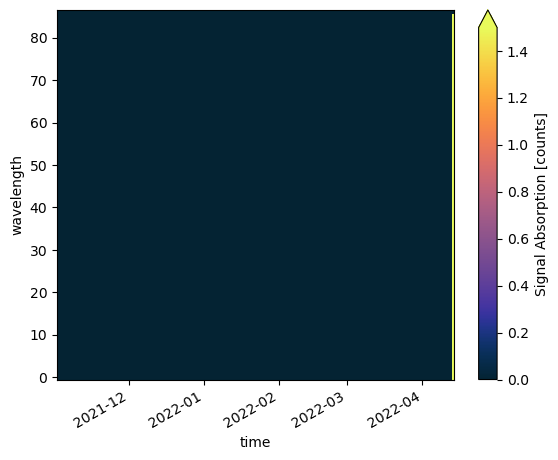

In [15]:
# plot subset of data with pcolormesh with time on xaxis and wavelength on y axis
a_signal.plot(x="time", y="wavelength", robust=False, cmap=cmo.thermal, vmin=0, vmax=1.5)

In [25]:
# plot trivariate histogram of optical absorption coefficient
# sns.set_theme(style="dark") # what other theme styles are available?

sns.heatmap(absorption)

MemoryError: 